In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import pandas as pd
import numpy as np
from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [3]:
vsibench = load_dataset("nyu-visionx/VSI-Bench")
df = vsibench["test"].to_pandas()

In [4]:
qdf = df[df["question_type"] == "obj_appearance_order"].copy()
qdf["question"].sample(3).values

array(['What will be the first-time appearance order of the following categories in the video: table, door, sofa, lamp?',
       'What will be the first-time appearance order of the following categories in the video: lamp, table, sofa, clock?',
       'What will be the first-time appearance order of the following categories in the video: backpack, microwave, refrigerator, counter?'],
      dtype=object)

In [5]:
import re

# question format: "What is the length of the longest dimension (length, width, or height) of the OBJECT, measured in centimeters?'"
# question format: "How many OBJECT(s) are in this room?"

qdf["gt_idx"] = qdf["ground_truth"].apply(lambda x: "ABCD".index(x))
qdf["gt_option"] = qdf.apply(lambda row: row["options"][row["gt_idx"]].split(". ")[-1], axis=1)

gt_objects_list_flat = [] # For overall frequency
# Assume sequences are always length 4
for i in range(4):
    gt_obj_i = qdf["gt_option"].apply(lambda x: x.split(", ")[i].strip())
    qdf[f"gt_obj_{i+1}"] = gt_obj_i # Add to dataframe
    gt_objects_list_flat.extend(gt_obj_i.dropna().tolist()) # Add to flat list

    qdf[f"opt_seq_{i+1}"] = qdf["options"].apply(lambda x: x[i].split(". ", 1)[1].split(", "))

gt_cols = [f"gt_obj_{i+1}" for i in range(4)]

qdf.head()

,id,dataset,scene_name,question_type,question,ground_truth,options,gt_idx,gt_option,gt_obj_1,opt_seq_1,gt_obj_2,opt_seq_2,gt_obj_3,opt_seq_3,gt_obj_4,opt_seq_4
2701,2713,scannetpp,45b0dac5e3,obj_appearance_order,What will be the first-time appearance order o...,A,"[A. cup, door, heater, ceiling light, B. ceili...",0,"cup, door, heater, ceiling light",cup,"[cup, door, heater, ceiling light]",door,"[ceiling light, door, cup, heater]",heater,"[heater, cup, door, ceiling light]",ceiling light,"[ceiling light, cup, heater, door]"
2702,2714,scannetpp,45b0dac5e3,obj_appearance_order,What will be the first-time appearance order o...,C,"[A. toilet, door, ceiling light, heater, B. he...",2,"toilet, door, heater, ceiling light",toilet,"[toilet, door, ceiling light, heater]",door,"[heater, toilet, door, ceiling light]",heater,"[toilet, door, heater, ceiling light]",ceiling light,"[ceiling light, door, toilet, heater]"
2703,2715,scannetpp,5942004064,obj_appearance_order,What will be the first-time appearance order o...,D,"[A. basket, blanket, toilet, ceiling light, B....",3,"toilet, basket, blanket, ceiling light",toilet,"[basket, blanket, toilet, ceiling light]",basket,"[blanket, toilet, basket, ceiling light]",blanket,"[toilet, ceiling light, basket, blanket]",ceiling light,"[toilet, basket, blanket, ceiling light]"
2704,2716,scannetpp,5942004064,obj_appearance_order,What will be the first-time appearance order o...,B,"[A. basket, table, bed, toilet, B. toilet, bas...",1,"toilet, basket, bed, table",toilet,"[basket, table, bed, toilet]",basket,"[toilet, basket, bed, table]",bed,"[toilet, bed, basket, table]",table,"[toilet, basket, table, bed]"
2705,2717,scannetpp,5942004064,obj_appearance_order,What will be the first-time appearance order o...,B,"[A. basket, door, pillow, ceiling light, B. do...",1,"door, basket, pillow, ceiling light",door,"[basket, door, pillow, ceiling light]",basket,"[door, basket, pillow, ceiling light]",pillow,"[basket, ceiling light, door, pillow]",ceiling light,"[pillow, door, basket, ceiling light]"


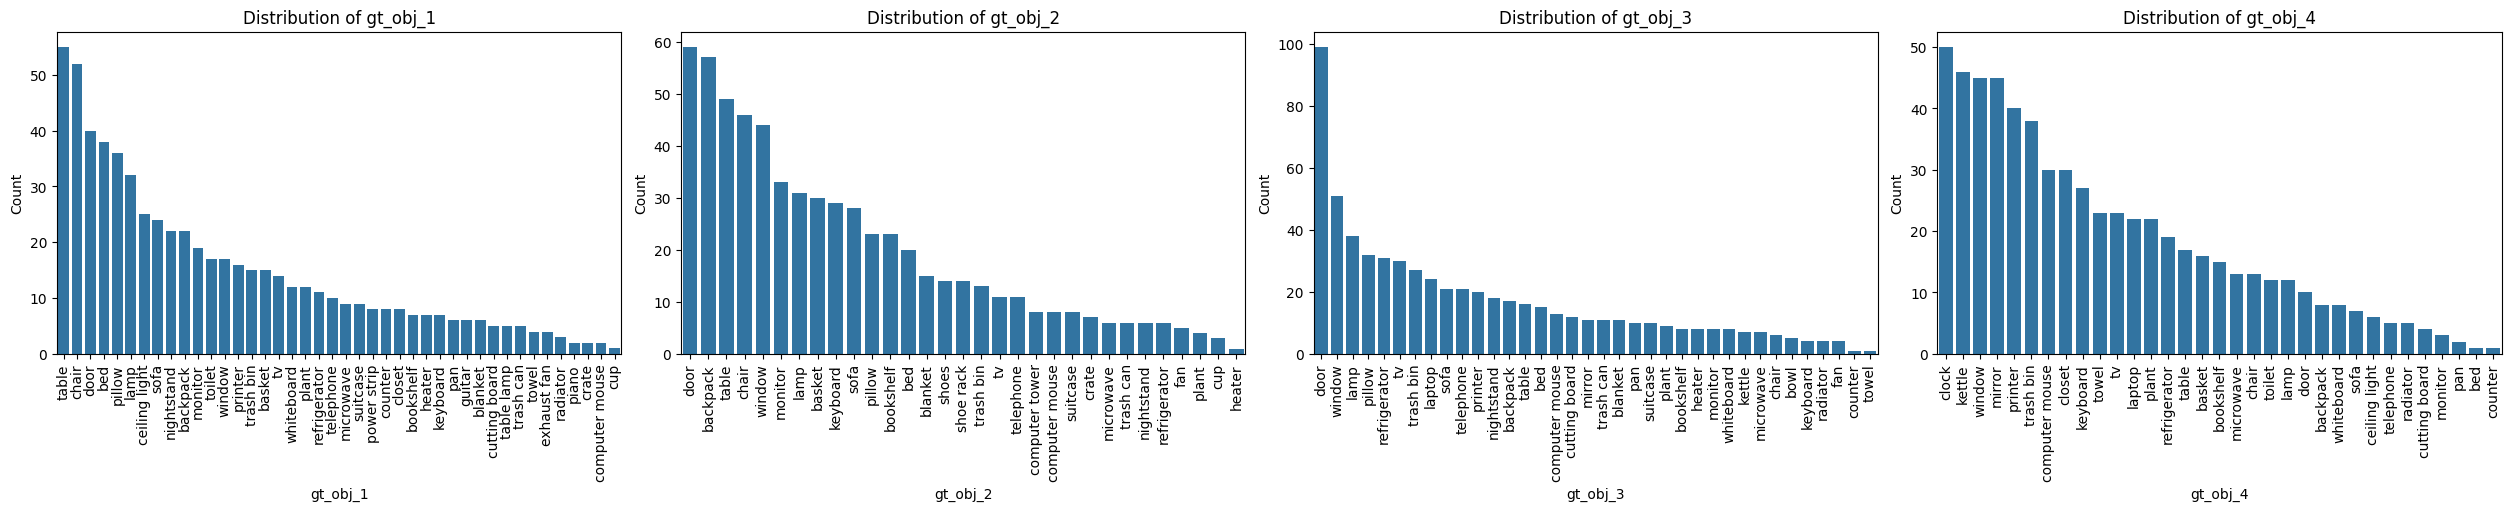

In [6]:
cols = ["gt_obj_1", "gt_obj_2", "gt_obj_3", "gt_obj_4"]

# Create subplots
fig, axes = plt.subplots(1, 4, figsize=(25, 5), constrained_layout=True)


for i, col in enumerate(cols):
    sns.countplot(data=qdf, x=col, order=qdf[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis='x', rotation=90)

plt.show()

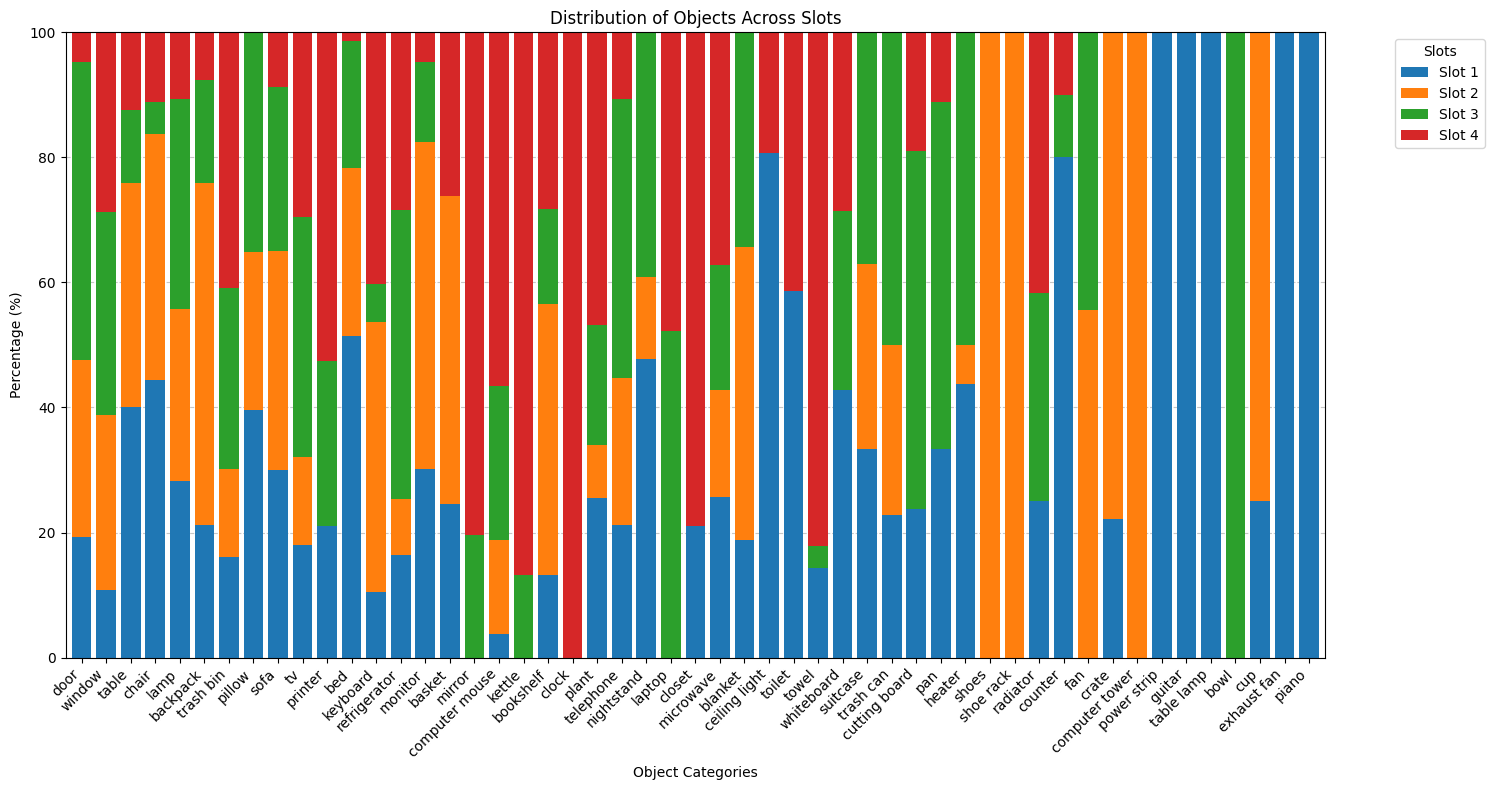

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

cols = ["gt_obj_1", "gt_obj_2", "gt_obj_3", "gt_obj_4"]

# Count occurrences of each object in each slot
object_slot_counts = {}
for i, col in enumerate(cols):
    slot_name = f'Slot {i+1}'
    value_counts = qdf[col].value_counts()
    for obj, count in value_counts.items():
        if obj not in object_slot_counts:
            object_slot_counts[obj] = {f'Slot {j+1}': 0 for j in range(4)}
        object_slot_counts[obj][slot_name] = count

# Convert to DataFrame
count_df = pd.DataFrame(object_slot_counts).T.fillna(0)

# Calculate percentages (each row sums to 100%)
percentage_df = count_df.div(count_df.sum(axis=1), axis=0) * 100

# Sort by total occurrences (optional - you can remove this line)
percentage_df = percentage_df.loc[count_df.sum(axis=1).sort_values(ascending=False).index]

# Create the stacked bar plot
fig, ax = plt.subplots(figsize=(15, 8))

# Create the stacked bars
percentage_df.plot(kind='bar', stacked=True, ax=ax, width=0.8)

# Customize the plot
ax.set_xlabel('Object Categories')
ax.set_ylabel('Percentage (%)')
ax.set_title('Distribution of Objects Across Slots')
ax.legend(title='Slots', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage grid
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Set y-axis to 0-100%
ax.set_ylim(0, 100)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

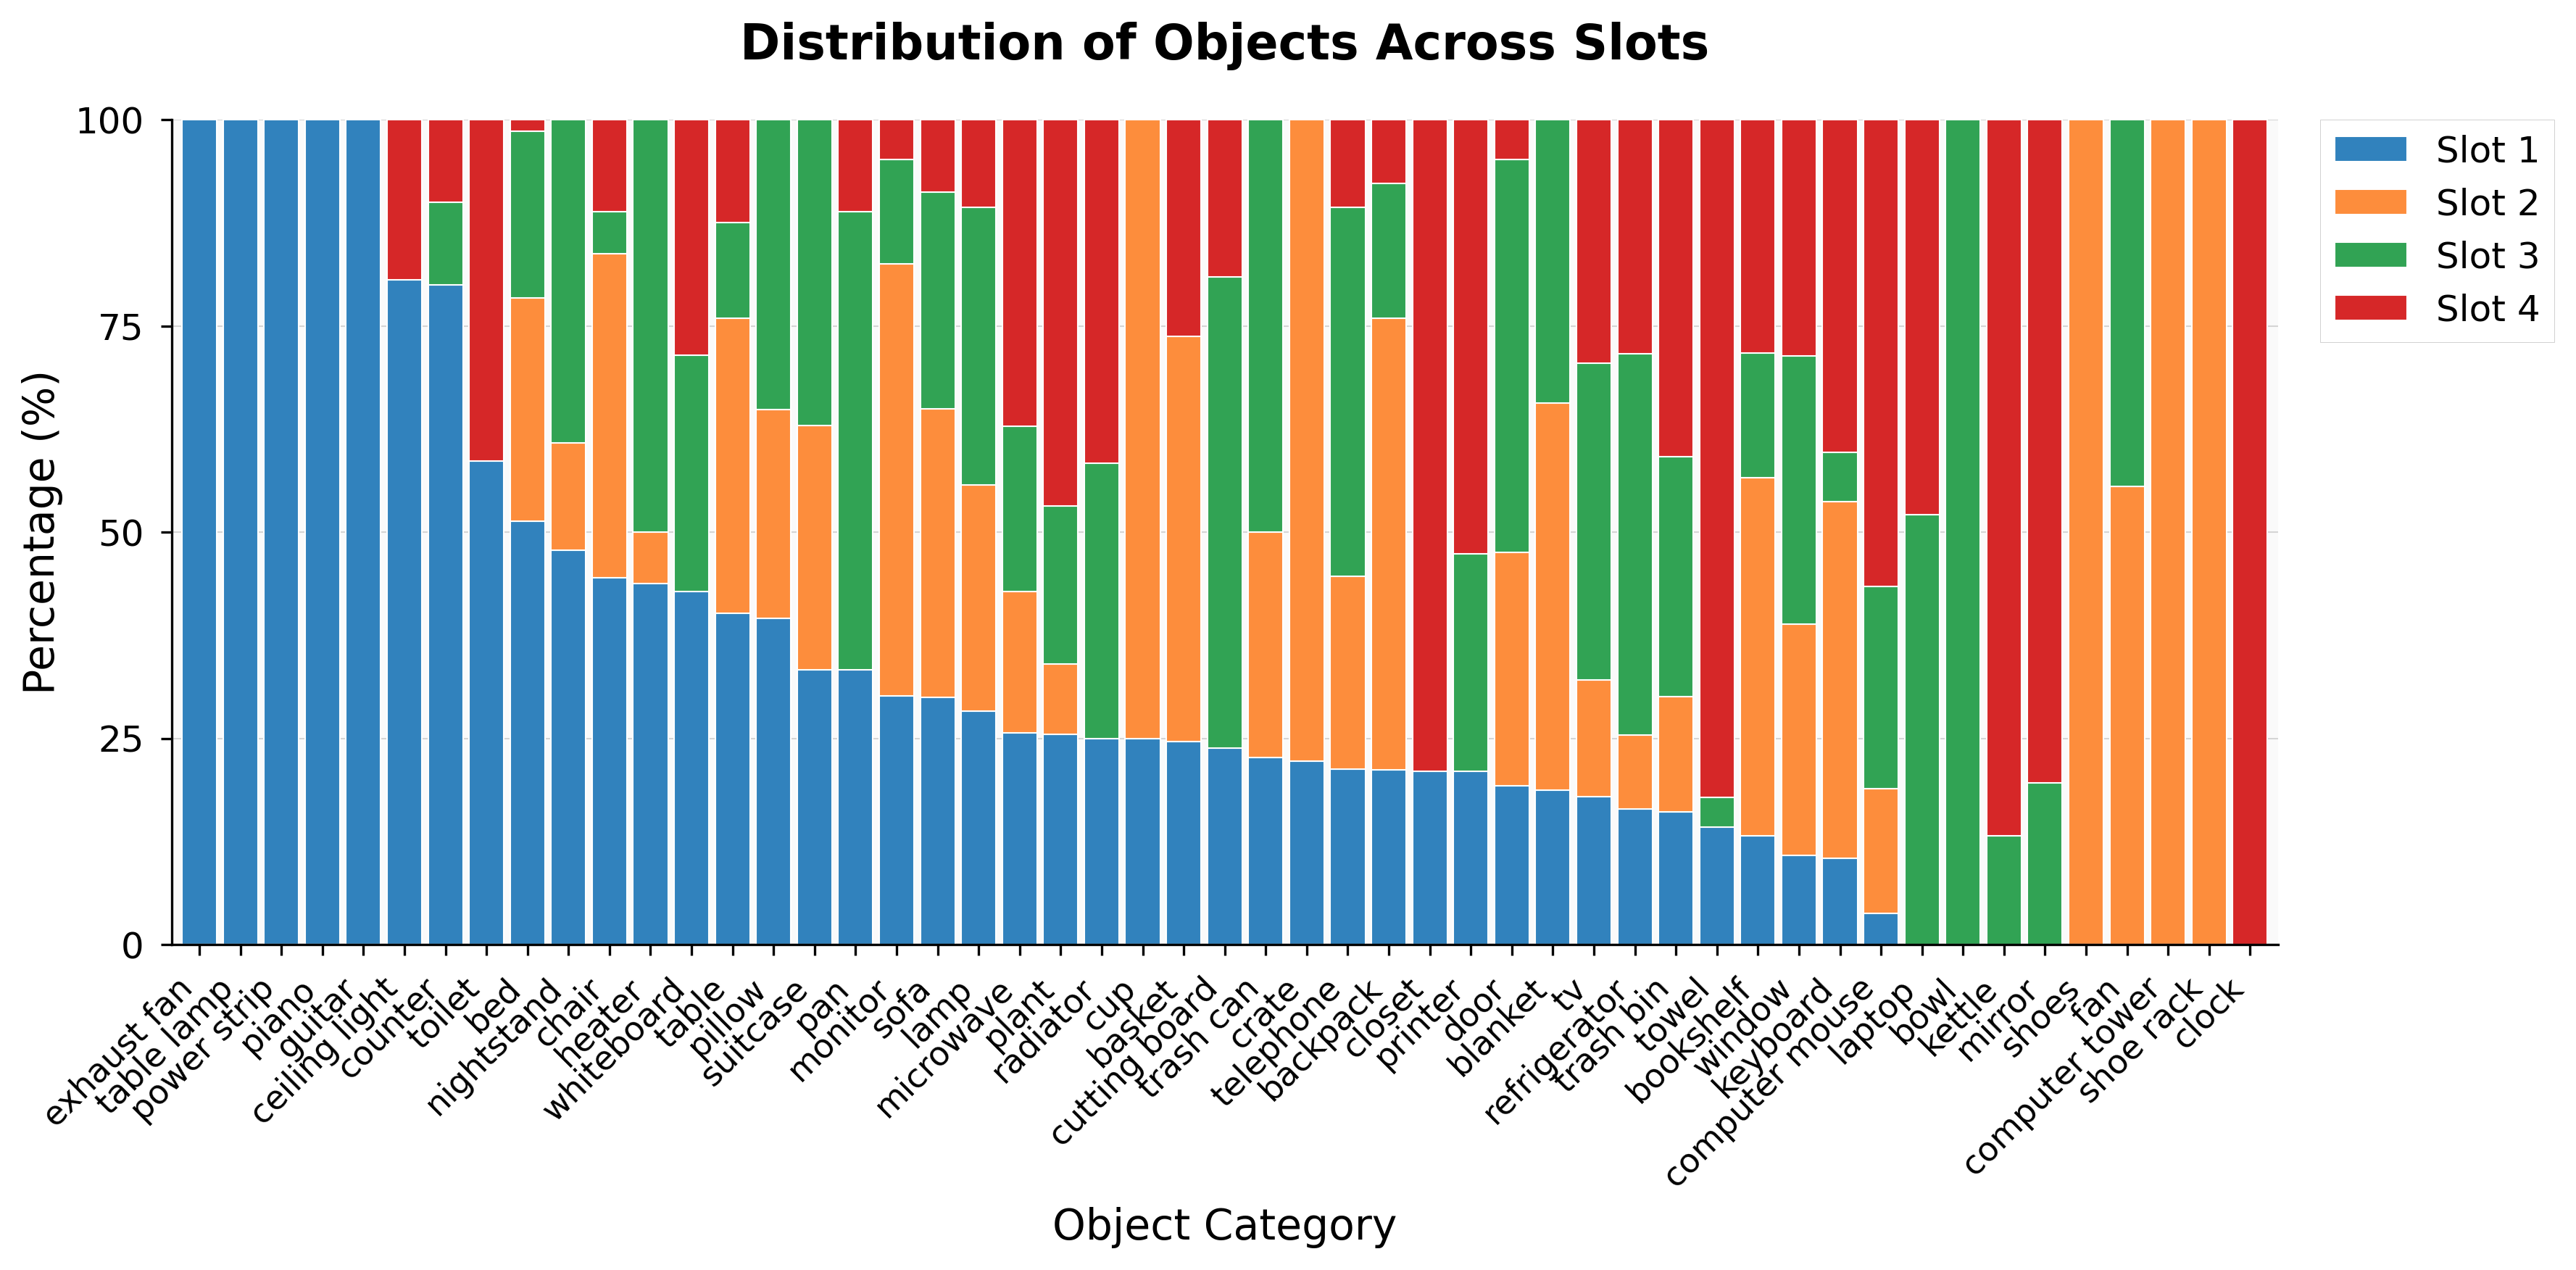

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set publication style
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.family'] = 'Times New Roman'

cols = ["gt_obj_1", "gt_obj_2", "gt_obj_3", "gt_obj_4"]

# Count occurrences of each object in each slot
object_slot_counts = {}
for i, col in enumerate(cols):
    slot_name = f'Slot {i+1}'
    value_counts = qdf[col].value_counts()
    for obj, count in value_counts.items():
        if obj not in object_slot_counts:
            object_slot_counts[obj] = {f'Slot {j+1}': 0 for j in range(4)}
        object_slot_counts[obj][slot_name] = count

# Convert to DataFrame
count_df = pd.DataFrame(object_slot_counts).T.fillna(0)

# Calculate percentages (each row sums to 100%)
percentage_df = count_df.div(count_df.sum(axis=1), axis=0) * 100

# Sort by Slot 1 percentage (descending)
percentage_df = percentage_df.sort_values('Slot 1', ascending=False)

# Create figure with higher DPI for publication
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

# Define a professional color palette (colorblind-friendly)
colors = ['#3182bd', '#fd8d3c', '#31a354', '#d62728']  # Blue, Orange, Green, Red

# Create the stacked bars with custom colors
percentage_df.plot(kind='bar', stacked=True, ax=ax, width=0.85, 
                   color=colors, edgecolor='white', linewidth=0.5)

# Customize the plot
ax.set_xlabel('Object Category', fontweight='medium')
ax.set_ylabel('Percentage (%)', fontweight='medium')
ax.set_title('Distribution of Objects Across Slots', fontweight='bold', pad=20)

# Improve legend
ax.legend(title='', frameon=True, fancybox=False, 
          bbox_to_anchor=(1.02, 1), loc='upper left',
          borderaxespad=0, framealpha=0.9)

# Add grid for readability
ax.yaxis.grid(True, linestyle='-', alpha=0.3, color='gray', linewidth=0.5)
ax.set_axisbelow(True)

# Set y-axis
ax.set_ylim(0, 100)
ax.set_yticks([0, 25, 50, 75, 100])

# Rotate x-axis labels and adjust
plt.xticks(rotation=45, ha='right')

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add subtle background
ax.set_facecolor('#fafafa')
fig.patch.set_facecolor('white')

# Tight layout with padding
plt.tight_layout()

# Save as high-quality PDF for paper submission
# plt.savefig('object_slot_distribution.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('object_slot_distribution.png', dpi=300, bbox_inches='tight')

plt.show()

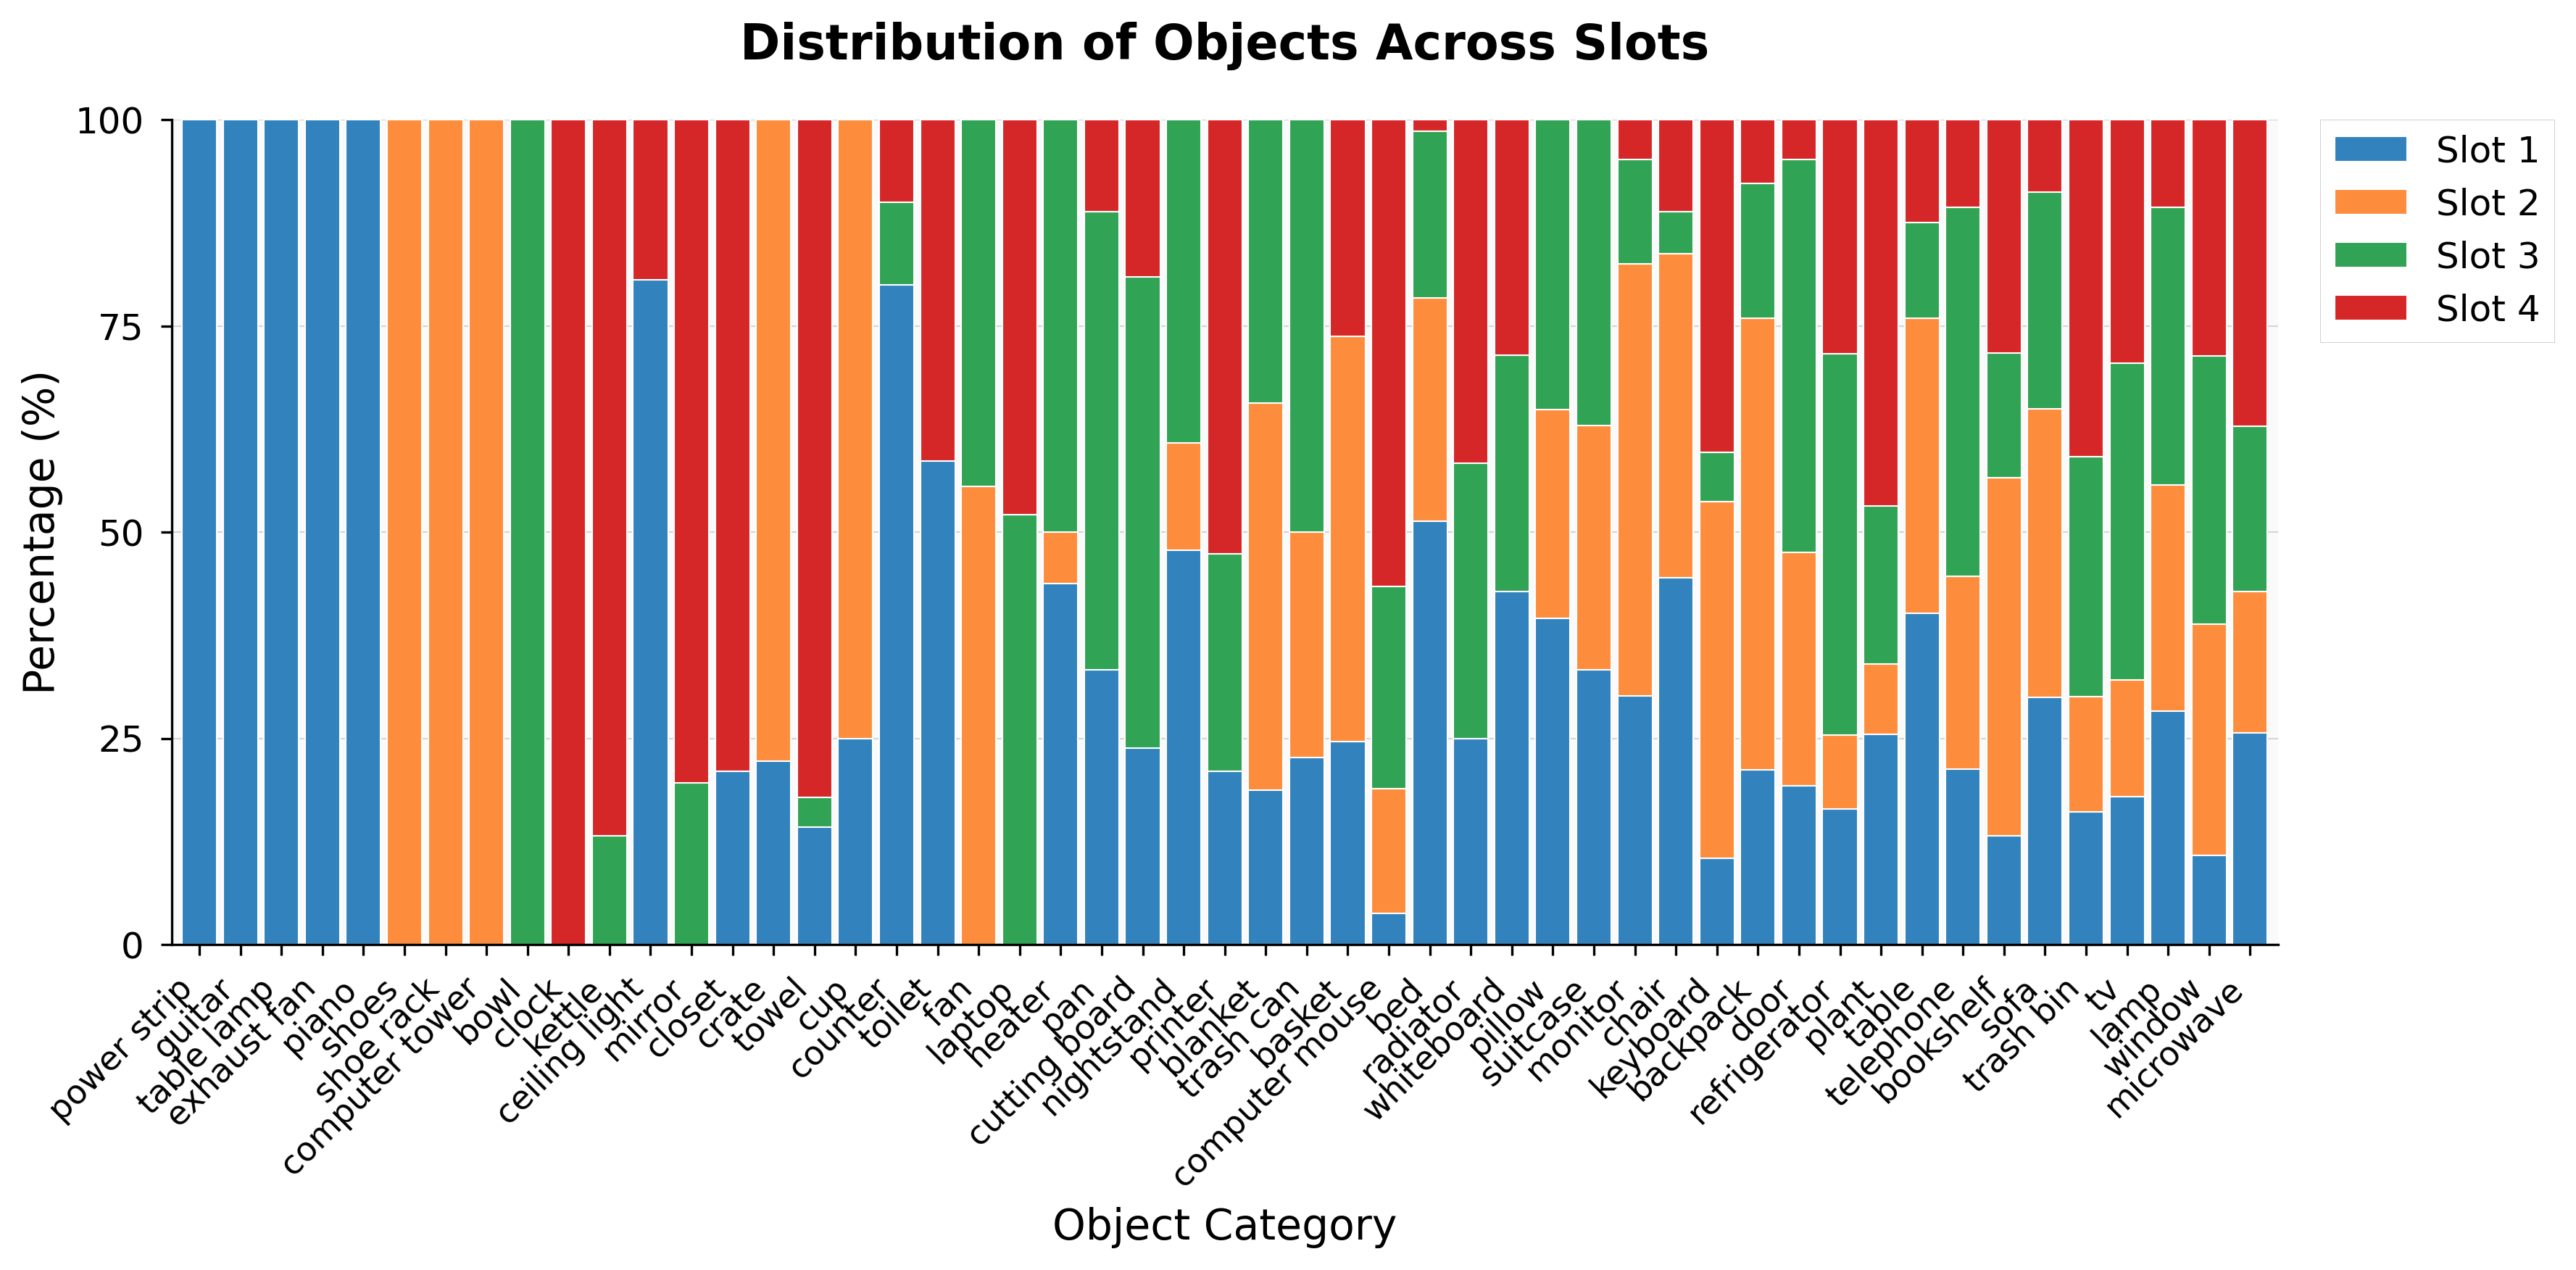

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Set publication style
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.family'] = 'Times New Roman'

cols = ["gt_obj_1", "gt_obj_2", "gt_obj_3", "gt_obj_4"]

# Count occurrences of each object in each slot
object_slot_counts = {}
for i, col in enumerate(cols):
    slot_name = f'Slot {i+1}'
    value_counts = qdf[col].value_counts()
    for obj, count in value_counts.items():
        if obj not in object_slot_counts:
            object_slot_counts[obj] = {f'Slot {j+1}': 0 for j in range(4)}
        object_slot_counts[obj][slot_name] = count

# Convert to DataFrame
count_df = pd.DataFrame(object_slot_counts).T.fillna(0)

# Calculate percentages (each row sums to 100%)
percentage_df = count_df.div(count_df.sum(axis=1), axis=0) * 100
# Calculate entropy for each row (object category)
def calculate_entropy(row):
    # Avoid log(0) by handling zeros
    probs = row / 100  # Convert percentages to probabilities
    probs = probs[probs > 0]  # Remove zeros
    return -np.sum(probs * np.log2(probs))

# Calculate entropy for each object category
percentage_df['entropy'] = percentage_df.apply(calculate_entropy, axis=1)

# Sort by entropy (ascending) - low entropy means concentrated in fewer slots
# Sort by entropy (ascending) and then by Slot 1 (descending)
percentage_df = percentage_df.sort_values(['entropy', 'Slot 1'], ascending=[True, False]).drop('entropy', axis=1)

# Create figure with higher DPI for publication
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

# Define a professional color palette (colorblind-friendly)
colors = ['#3182bd', '#fd8d3c', '#31a354', '#d62728']  # Blue, Orange, Green, Red

# Create the stacked bars with custom colors
percentage_df.plot(kind='bar', stacked=True, ax=ax, width=0.85, 
                   color=colors, edgecolor='white', linewidth=0.5)

# Customize the plot
ax.set_xlabel('Object Category', fontweight='medium')
ax.set_ylabel('Percentage (%)', fontweight='medium')
ax.set_title('Distribution of Objects Across Slots', fontweight='bold', pad=20)

# Improve legend
ax.legend(title='', frameon=True, fancybox=False, 
          bbox_to_anchor=(1.02, 1), loc='upper left',
          borderaxespad=0, framealpha=0.9)

# Add grid for readability
ax.yaxis.grid(True, linestyle='-', alpha=0.3, color='gray', linewidth=0.5)
ax.set_axisbelow(True)

# Set y-axis
ax.set_ylim(0, 100)
ax.set_yticks([0, 25, 50, 75, 100])

# Rotate x-axis labels and adjust
plt.xticks(rotation=45, ha='right')

# Remove top and right spines for cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add subtle background
ax.set_facecolor('#fafafa')
fig.patch.set_facecolor('white')

# Tight layout with padding
plt.tight_layout()

# Save as high-quality PDF for paper submission
# plt.savefig('object_slot_distribution.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('object_slot_distribution.png', dpi=300, bbox_inches='tight')

plt.show()

# Debiasing

In [10]:
from sklearn.preprocessing import minmax_scale
from collections import Counter


# --- 1. Extract All Object Sequences ---
qdf["gt_idx"] = qdf["ground_truth"].apply(lambda x: "ABCD".index(x))
qdf["gt_option"] = qdf.apply(lambda row: row["options"][row["gt_idx"]].split(". ")[-1], axis=1)

gt_objects_list_flat = [] # For overall frequency
# Assume sequences are always length 4
for i in range(4):
    gt_obj_i = qdf["gt_option"].apply(lambda x: x.split(", ")[i].strip())
    qdf[f"gt_obj_{i+1}"] = gt_obj_i # Add to dataframe
    gt_objects_list_flat.extend(gt_obj_i.dropna().tolist()) # Add to flat list

    qdf[f"opt_seq_{i+1}"] = qdf["options"].apply(lambda x: x[i].split(". ", 1)[1].split(", "))

# --- 2. Calculate Frequencies (using only GT sequences for stats) ---
position_freq = Counter()
for i in range(1, 5):
    counts = qdf[f"gt_obj_{i}"].value_counts()
    for obj, count in counts.items(): position_freq[(obj, i)] += count
pair_freq = Counter()
for i in range(1, 4):
    pair = tuple(zip(qdf[f"gt_obj_{i}"], qdf[f"gt_obj_{i+1}"]))
    pair_freq.update(pair)
comb_pair_freq = Counter()
for i in range(1, 5):
    for j in range(i + 1, 5):
        pair = tuple(zip(qdf[f"gt_obj_{i}"], qdf[f"gt_obj_{j}"]))
        comb_pair_freq.update(pair)

if not position_freq or not pair_freq:
    raise ValueError("No valid frequencies found.")

# --- 3. Normalize Frequencies ---
pos_freq_values = np.array(list(position_freq.values())).reshape(-1, 1)
pair_freq_values = np.array(list(pair_freq.values())).reshape(-1, 1)
comb_pair_freq_values = np.array(list(comb_pair_freq.values())).reshape(-1, 1)

scaled_pos_freq_values = minmax_scale(pos_freq_values) if len(np.unique(pos_freq_values)) > 1 else np.ones_like(pos_freq_values)
scaled_pair_freq_values = minmax_scale(pair_freq_values) if len(np.unique(pair_freq_values)) > 1 else np.ones_like(pair_freq_values)
scaled_comb_pair_freq_values = minmax_scale(comb_pair_freq_values) if len(np.unique(comb_pair_freq_values)) > 1 else np.ones_like(comb_pair_freq_values)

norm_pos_freq_map = {key: scaled_pos_freq_values[i][0] for i, key in enumerate(position_freq.keys())}
norm_pair_freq_map = {key: scaled_pair_freq_values[i][0] for i, key in enumerate(pair_freq.keys())}
norm_comb_pair_freq_map = {key: scaled_comb_pair_freq_values[i][0] for i, key in enumerate(comb_pair_freq.keys())}

# --- 4. Calculate Relative Bias Score ---
bias_infos = []
for index, row in qdf.iterrows():
    gt_idx = row['gt_idx']

    # gt_score = all_scores[gt_idx]
    # distractor_scores = [all_scores[i] for i in range(4) if i != gt_idx]
    # max_distractor_score = max(distractor_scores) if distractor_scores else 0

    # relative_score = gt_score - max_distractor_score
    bias_info = {'id': row['id']}
    max_distractor_pos_score = float('-inf')
    max_distractor_pair_score = float('-inf')
    max_distractor_comb_pair_score = float('-inf')
    max_distractor_score = float('-inf')
    # for i, seq in enumerate(options_sequences):
    for i in range(4):
        seq = row[f"opt_seq_{i+1}"]
        pos_score = pair_score = comb_pair_score = 0
        for j, obj in enumerate(seq):
            pos_score += norm_pos_freq_map.get((obj, j + 1), 0)
            if j < len(seq) - 1:
                pair = (seq[j], seq[j + 1])
                pair_score += norm_pair_freq_map.get(pair, 0)
            for k in range(j + 1, len(seq)):
                pair = (seq[j], seq[k])
                comb_pair_score += norm_comb_pair_freq_map.get(pair, 0)

        score = (pos_score + pair_score + comb_pair_score) / 3 # Normalize by 3 components
        bias_info[f'seq_{i}_pos_score'] = pos_score
        bias_info[f'seq_{i}_pair_score'] = pair_score
        bias_info[f'seq_{i}_comb_pair_score'] = comb_pair_score
        bias_info[f'seq_{i}_score'] = score
        if i == gt_idx:
            bias_info['gt_pos_score'] = pos_score
            bias_info['gt_pair_score'] = pair_score
            bias_info['gt_comb_pair_score'] = comb_pair_score
            bias_info['gt_obj_score'] = score
        else:
            max_distractor_pos_score = max(max_distractor_pos_score, pos_score)
            max_distractor_pair_score = max(max_distractor_pair_score, pair_score)
            max_distractor_comb_pair_score = max(max_distractor_comb_pair_score, comb_pair_score)
            max_distractor_score = max(max_distractor_score, score)

    bias_info['max_distractor_pos_score'] = max_distractor_pos_score
    bias_info['max_distractor_pair_score'] = max_distractor_pair_score
    bias_info['max_distractor_comb_pair_score'] = max_distractor_comb_pair_score
    bias_info['max_distractor_score'] = max_distractor_score

    bias_info['relative_bias_pos_score'] = bias_info['gt_pos_score'] - max_distractor_pos_score
    bias_info['relative_bias_pair_score'] = bias_info['gt_pair_score'] - max_distractor_pair_score
    bias_info['relative_bias_comb_pair_score'] = bias_info['gt_comb_pair_score'] - max_distractor_comb_pair_score
    # bias_info['relative_bias_score'] = bias_info['gt_obj_score'] - max_distractor_score
    # recalculate relative bias score using the differences in scores and then multiply by weights
    bias_info['relative_bias_score'] = (
        bias_info['relative_bias_pos_score'] +
        bias_info['relative_bias_pair_score'] +
        bias_info['relative_bias_comb_pair_score']
    ) / 3

    bias_infos.append(bias_info)

# Create DataFrame from bias_infos
bias_df = pd.DataFrame(bias_infos)

# Merge with original DataFrame to keep all columns
merged_df = pd.merge(qdf, bias_df, on='id', how='left')

In [12]:
merged_df.columns

Index(['id', 'dataset', 'scene_name', 'question_type', 'question',
       'ground_truth', 'options', 'gt_idx', 'gt_option', 'gt_obj_1',
       'opt_seq_1', 'gt_obj_2', 'opt_seq_2', 'gt_obj_3', 'opt_seq_3',
       'gt_obj_4', 'opt_seq_4', 'seq_0_pos_score', 'seq_0_pair_score',
       'seq_0_comb_pair_score', 'seq_0_score', 'gt_pos_score', 'gt_pair_score',
       'gt_comb_pair_score', 'gt_obj_score', 'seq_1_pos_score',
       'seq_1_pair_score', 'seq_1_comb_pair_score', 'seq_1_score',
       'seq_2_pos_score', 'seq_2_pair_score', 'seq_2_comb_pair_score',
       'seq_2_score', 'seq_3_pos_score', 'seq_3_pair_score',
       'seq_3_comb_pair_score', 'seq_3_score', 'max_distractor_pos_score',
       'max_distractor_pair_score', 'max_distractor_comb_pair_score',
       'max_distractor_score', 'relative_bias_pos_score',
       'relative_bias_pair_score', 'relative_bias_comb_pair_score',
       'relative_bias_score'],
      dtype='object')

In [18]:

merged_df.head(3)

,id,dataset,scene_name,question_type,question,ground_truth,options,gt_idx,gt_option,gt_obj_1,...,seq_3_comb_pair_score,seq_3_score,max_distractor_pos_score,max_distractor_pair_score,max_distractor_comb_pair_score,max_distractor_score,relative_bias_pos_score,relative_bias_pair_score,relative_bias_comb_pair_score,relative_bias_score
0,2713,scannetpp,45b0dac5e3,obj_appearance_order,What will be the first-time appearance order o...,A,"[A. cup, door, heater, ceiling light, B. ceili...",0,"cup, door, heater, ceiling light",cup,...,0.081081,0.181378,1.132653,0.034483,0.135135,0.422596,-0.418367,0.034483,0.000000,-0.127962
1,2714,scannetpp,45b0dac5e3,obj_appearance_order,What will be the first-time appearance order o...,C,"[A. toilet, door, ceiling light, heater, B. he...",2,"toilet, door, heater, ceiling light",toilet,...,0.162162,0.344460,1.112245,0.034483,0.243243,0.451829,-0.234694,0.034483,-0.054054,-0.084755
2,2715,scannetpp,5942004064,obj_appearance_order,What will be the first-time appearance order o...,D,"[A. basket, blanket, toilet, ceiling light, B....",3,"toilet, basket, blanket, ceiling light",toilet,...,0.972973,0.827257,0.336735,0.517241,0.918919,0.487165,0.275510,0.379310,0.054054,0.236292


In [ ]:
import numpy as np # Added for mean/std calculation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer # Added make_scorer for cross_val_score
from sklearn.model_selection import StratifiedKFold, cross_val_score # Added KFold and cross_val_score
from sklearn.preprocessing import LabelEncoder


feature_cols = [
    'opt_seq_1', 
    'opt_seq_2',
    'opt_seq_3',
    'opt_seq_4', 'seq_0_pos_score', 'seq_0_pair_score',
    'seq_0_comb_pair_score', 'seq_0_score', 'gt_pos_score', 'gt_pair_score',
    'gt_comb_pair_score', 'gt_obj_score', 'seq_1_pos_score',
    'seq_1_pair_score', 'seq_1_comb_pair_score', 'seq_1_score',
    'seq_2_pos_score', 'seq_2_pair_score', 'seq_2_comb_pair_score',
    'seq_2_score', 'seq_3_pos_score', 'seq_3_pair_score',
    'seq_3_comb_pair_score', 'seq_3_score', 'max_distractor_pos_score',
    'max_distractor_pair_score', 'max_distractor_comb_pair_score',
    'max_distractor_score', 'relative_bias_pos_score',
    'relative_bias_pair_score', 'relative_bias_comb_pair_score',
    'relative_bias_score'
]
target_col = "ground_truth"

def evaluate_rf_bias_cv(df: pd.DataFrame, n_splits: int = 5, feature_cols=feature_cols, target_col=target_col) -> tuple[float, float, pd.DataFrame]:
    """
    Trains and evaluates a RandomForestClassifier using k-fold cross-validation
    on non-visual features of object_rel_distance questions to predict the
    ground truth answer ('A'/'B'/'C'/'D').

    Args:
        df
        n_splits: Number of folds for StratifiedKFold cross-validation.

    Returns:
        A tuple containing:
        - mean_accuracy (float): Mean accuracy across the cross-validation folds.
        - std_accuracy (float): Standard deviation of accuracy across the folds.
        - feature_importance_df (pd.DataFrame | None): DataFrame with feature importances
            from a model trained on the full dataset, or None if calculation fails.
    """
    print(f"--- Starting RF Bias Evaluation (CV with {n_splits} splits) ---")

    # Check for essential columns
    required_cols = feature_cols + [target_col]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        print(f"Error: Input DataFrame is missing required columns: {missing_cols}")
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Create a working copy and drop rows with missing values in relevant columns
    data = df[required_cols].copy()
    initial_rows = len(data)
    data.dropna(inplace=True)
    final_rows = len(data)
    if final_rows < initial_rows:
        print(f"Warning: Dropped {initial_rows - final_rows} rows due to missing values in features or target.")

    if data.empty:
        print("Error: DataFrame is empty after dropping NA. Cannot proceed.")
        raise ValueError("DataFrame is empty after dropping NA.")

    X = data[feature_cols]
    y = data[target_col]

    print(f"Using {len(X)} samples for evaluation.")

    # --- 2. Preprocess Features ---
    encoders = {}
    X_encoded = X.copy()
    categorical_cols = X.select_dtypes(include='object').columns

    if not categorical_cols.empty:
        print(f"Encoding categorical features: {list(categorical_cols)}")
        for col in categorical_cols:
            encoders[col] = LabelEncoder()
            # Fit on the entire column before cross-validation
            X_encoded[col] = encoders[col].fit_transform(X_encoded[col].astype(str))
    else:
        print("No categorical features found to encode.")

    # --- 3. Define Model and Cross-Validation Strategy ---
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    # Adjust n_splits if necessary based on class distribution
    min_samples_per_class = y.value_counts().min()
    if min_samples_per_class < n_splits:
        print(f"Warning: The least populated class has only {min_samples_per_class} samples.")
        if min_samples_per_class < 2:
            print("Error: The least populated class has less than 2 samples. Cannot perform stratified CV.")
            raise ValueError("Insufficient samples in the smallest class for stratified CV.")
        print(f"Reducing n_splits from {n_splits} to {min_samples_per_class} to match the smallest class size.")
        n_splits = min_samples_per_class

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # --- 4. Perform Cross-Validation ---
    print(f"Performing {n_splits}-Fold Cross-Validation...")
    try:
        # Use cross_val_score to get accuracy for each fold
        scores = cross_val_score(model, X_encoded, y, cv=cv, scoring='accuracy', n_jobs=-1)
        mean_accuracy = np.mean(scores)
        std_accuracy = np.std(scores)
        print(f"Scores for each fold: {scores}")
        print(f"Mean Accuracy: {mean_accuracy:.4f}")
        print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")
    except ValueError as e:
        print(f"Error during cross-validation: {e}")
        print("This might happen if a fold doesn't contain samples from all classes, especially with small datasets.")
        return np.nan, np.nan, None # Return NaN if CV fails

    # --- 5. Train Final Model and Get Feature Importances ---
    feature_importance_df = None # Initialize as None
    print("\nTraining final model on all data to get feature importances...")
    try:
        final_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        final_model.fit(X_encoded, y)
        importances = final_model.feature_importances_
        feature_importance_df = pd.DataFrame({'feature': X_encoded.columns, 'importance': importances})
        feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)
        print("\nFeature Importances (from final model trained on all data):")
        print(feature_importance_df)
    except Exception as e:
        print(f"Could not calculate feature importances: {e}")

    print("--- Evaluation Complete ---")
    return mean_accuracy, std_accuracy, feature_importance_df

evaluate_rf_bias_cv(merged_df, n_splits=5);

--- Starting RF Bias Evaluation (CV with 5 splits) ---
Using 618 samples for evaluation.
Encoding categorical features: ['opt_seq_3', 'opt_seq_1', 'opt_seq_2', 'opt_seq_4']
Performing 5-Fold Cross-Validation...
Scores for each fold: [0.81451613 0.84677419 0.86290323 0.84552846 0.81300813]
Mean Accuracy: 0.8365
Standard Deviation of Accuracy: 0.0196

Training final model on all data to get feature importances...

Feature Importances (from final model trained on all data):
                           feature  importance
0                 seq_0_pair_score    0.071345
1                 seq_2_pair_score    0.070160
2                 seq_3_pair_score    0.064369
3                 seq_1_pair_score    0.062091
4                      seq_2_score    0.053791
5                      seq_3_score    0.052834
6                      seq_1_score    0.052325
7                      seq_0_score    0.050557
8                  seq_1_pos_score    0.037752
9            seq_3_comb_pair_score    0.034611
10     